In [101]:
import numpy as np
import matplotlib.pyplot as plt

from testers import get_area_map, get_random_coords, imshow, imshow_scatter
from testers import get_all_area_maps, is_valid
from testers import generate_no_obs_area_map, generate_point_obstacles

from cpp_algorithms import dist_fill
from cpp_algorithms.fuel_path.fuel_path_helpers import get_step
from copy import deepcopy
import time

In [14]:
def bt_len(backtrack_paths):
    return np.sum([len(bt) for bt in backtrack_paths])

In [2]:
def print_map(area_map):
    for i in area_map:
        for j in i:
            print(f"{j}".rjust(3),end="")
        print()
        
def max_pool(matrix):
    """
    Performs max pooling with stride 2
    width and height should be even.
    """
    h,w = matrix.shape
    a = []
    for i in range(2):
        for j in range(2):
            a.append(matrix[i::2,j::2])
    return np.stack(a).max(axis=0).reshape(h//2,w//2)

def upscale(source):
    """
    Scales up each pixel by 2
    """
    h,w = source.shape
    dest = np.ones((h*2,w*2))
    dest[0::2,0::2] = source
    dest[1::2,0::2] = source
    dest[0::2,1::2] = source
    dest[1::2,1::2] = source
    return dest

In [3]:
def update_keeper(keeper, next_point):
    """
    Update values of the keeper dict.
    """
    keeper["prev_point"] = keeper["curr_point"]
    keeper["curr_point"] = next_point
    keeper["coverage_path"].append(next_point)
    
    # If everything works this conditional 
    # should evaluate to True always
    if not keeper["is_visited"][next_point]:
        keeper["is_visited"][next_point] = True
        return True
    return False
    
def get_next_valid(c_point, keeper, obstacle):
    """
    Checks points (RDLU) for one with max dist
    and not yet visited.
    """
    rdlu = lambda p:np.array([(p[0],p[1]+1),(p[0]+1,p[1]),\
                              (p[0],p[1]-1),(p[0]-1,p[1])])
    max_ = -1
    next_point = None
    for possible_point in rdlu(c_point):
        possible_point = tuple(possible_point)
        """
        is_valid = True if the point is within bounds and 
        hasn't been visited previously.
        """
        if is_valid(possible_point, keeper["is_visited"], obstacle=True):
            d_val = keeper["dist_map"][possible_point]
            if d_val > max_:
                max_ = d_val
                next_point = possible_point
    return next_point 

def backtrack_subroutine(keeper, obstacle):
    """
    Go back the coverage path, keep adding to the backtrack
    path, once a viable point is reached, stop, record backtrack
    path and backtrack start.
    """
    # Should be True : backtrack_start == backtrack_path[0].
    backtrack_start = len(keeper["coverage_path"]) - 1 # last index of coverage_path
    covered_path = keeper["coverage_path"][::-1] # reversed coverage_path
    backtrack_path = []
    
    # Covered points are obstacles.
    covered_map = dist_map.copy()
    x,y = np.array(covered_path).T
    covered_map[x,y] = obstacle
    
    for bt_point in covered_path:
        backtrack_path.append(bt_point)
        next_point = get_next_valid(bt_point, keeper, obstacle)
        if next_point is not None:
            """
            keeper["backtrack_paths"] stores all `backtrack_path` lists
            keeper["backtrack_starts"] stores indices where the backtracking
                starts in the main keeper["coverage_path"] list.
            all elements in a `backtrack_path` are present in the `coverage_path`.
            """
            keeper["backtrack_paths"].append(backtrack_path)
            keeper["backtrack_starts"].append(backtrack_start)
            return next_point
    else:
        raise Exception("backtrack failed", covered_path[::-1])

def wavefront_update(keeper, obstacle):
    c_point = keeper["curr_point"]
    is_new = False
    next_point = get_next_valid(c_point, keeper, obstacle)
    
    if next_point is not None:
        # non backtrack condition.
        is_new = update_keeper(keeper, next_point)
    else:
        # backtrack condition, no viable point found
        next_point = backtrack_subroutine(keeper, obstacle)
        is_new = update_keeper(keeper, next_point)
    
    # is_new should always be True,
    # else backtrack has failed and there is an error,
    # or the map has locked in regions.
    return is_new

In [4]:
def wavefront_follow(dist_map, start_point, obstacle):
    # Matrix of values visited.
    is_visited = np.full(dist_map.shape,False)
    is_visited[dist_map==-1] = True
    is_visited[start_point] = True
    
    # Number of points to cover.
    points_to_cover = dist_map.size - (dist_map == obstacle).sum() - 1
    
    keeper = {
        "is_backtracking":False,
        "curr_point": start_point,
        "prev_point": start_point,
        "coverage_path": [start_point],
        "backtrack_paths": [],
        "backtrack_starts": [],
        "is_visited": is_visited,
        "dist_map": dist_map
    }
    
    while points_to_cover > 0:
        is_new = wavefront_update(keeper, obstacle)
#         print(points_to_cover, keeper["curr_point"], is_new)
#         print(is_visited.sum())
        if is_new:
            points_to_cover -= 1
    return keeper["coverage_path"], keeper["backtrack_paths"], keeper["backtrack_starts"]

In [5]:
def wavefront(area_map, start_point, center_point, obstacle=-1):
    """
    start_point, center_point : form (x,y)
    
    return :
        coverage_path : path followed on for coverage
        backtrack_paths : paths followed to get to uncovered point, 
            subsets of coverage_path.
        backtrack_starts : starting indices of the backtrack paths
    """
    assert is_valid(start_point, area_map, obstacle), "invalid start"
    assert is_valid(center_point, area_map, obstacle), "invalid center"
    
    dist_map = dist_fill(area_map, [center_point])
    return wavefront_follow(dist_map, start_point, obstacle)

In [6]:
area_maps = get_all_area_maps("./test_maps/")

CPU times: user 58.7 ms, sys: 2.46 ms, total: 61.2 ms
Wall time: 60.9 ms
backtrack length : 415, coverage length : 1318


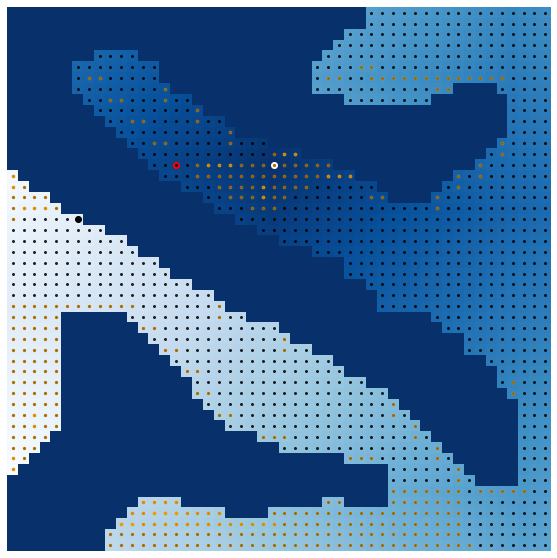

In [173]:
area_map = area_maps[10]
start_point = get_random_coords(area_map, 1)[0]
center_point = get_random_coords(area_map,1)[0]
dist_map = dist_fill(area_map,[center_point])
# print("sp",start_point, "\ncp",center_point)

%time coverage_path , backtrack_paths, backtrack_starts = wavefront(area_map, start_point, center_point)

imshow(dist_map, cmap="Blues_r", figsize=(10,10))


plt.scatter(start_point[1],start_point[0], color="black")   # Path Start
plt.scatter(center_point[1],center_point[0], color="white") # Distance Map Center
plt.scatter(coverage_path[-1][1],coverage_path[-1][0], color="red") # Path End
imshow_scatter(coverage_path, "black", 0.8, 4) # Main Path
for backtrack_path in backtrack_paths: 
    imshow_scatter(backtrack_path, "orange", 0.5, 7) # Backtrack Paths
    
print(f"backtrack length : {bt_len(backtrack_paths)}, coverage length : {len(coverage_path)}")

In [138]:
get_adj = lambda x,y :[
    (x+1,y),(x-1,y),(x,y+1),(x,y-1)
]
def has_isolated_areas(area_map, obstacle=-1):
    """
    Flood fills the area to check if there are 
    isolated areas.
    """
    
    v_map = (area_map == obstacle).copy()
    f_point = get_random_coords(area_map, 1, obstacle)[0]
    to_visit = [f_point]
    
    while len(to_visit) > 0:
        l = len(to_visit)
        for point in to_visit:
            v_map[point] = True
            
        for i in range(l):
            for adj_point in get_adj(*to_visit.pop(0)):
                if is_valid(adj_point, area_map, obstacle) \
                    and not v_map[adj_point] \
                    and adj_point not in to_visit:
                    to_visit.append(adj_point)
                    
    if v_map.sum() == v_map.size:
        return False
    return True

In [54]:
# 4 directions is faster (~deux fois) than 8.
timing_map = generate_no_obs_area_map([(100,100)])[0]
%timeit -n 10 -r 10 has_isolated_areas(timing_map)

81.6 ms ± 3 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


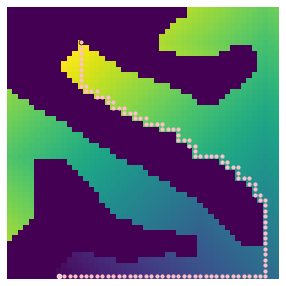

In [191]:
start_point = get_random_coords(area_map,1)[0]
end_point = get_random_coords(area_map,1)[0]
# start_point = (5,8)
# end_point = (15,16)
path_map = shortest_path_l1(start_point, end_point, area_map)
imshow(path_map)
imshow_scatter([start_point], "black",1,20)
imshow_scatter([end_point], "white",1,20)
sp_path = shortest_l1_path(start_point, end_point, area_map)
imshow_scatter(sp_path, "pink", 1, 10)

In [193]:
"""
Helpers to get the replacement paths for all the backtracked values.
"""
get_adj = lambda x,y :[
    (x+1,y),(x-1,y),(x,y+1),(x,y-1)
]

def get_step(path_map, next_point, obstacle=-1):
    min_d_val = path_map[next_point]
    possible_point = None
    for adj_point in get_adj(*next_point):
        if is_valid(adj_point, path_map, obstacle):
            d_val = path_map[adj_point]
            if d_val < min_d_val:
                min_d_val = d_val
                possible_point = adj_point
    return possible_point, min_d_val

def get_path(path_map, start_point, end_point, obstacle=-1):
    """
    Get the shortest (directed) l1 distance
    between `start_point`, `end_point` for a given `path_map`.
    
    (directed ∵ distance should be min at end_point)
    """
    path = [start_point]
    end_val = path_map[end_point]
    cell = path_map[start_point]
    next_point = start_point
    while cell != end_val:
        next_point, cell = get_step(path_map, next_point, obstacle)
        path.append(next_point)
    return path

def wave_find_map(start_point, end_point, area_map, obstacle=-1):
    """
    Creates a path map, which is a dist map that terminates once
    the required point is found.
    """
    AREA_VAL = 0
    d_map = area_map.copy()
    v_map = (area_map == obstacle).copy()
    to_visit = [end_point]
    def loop():
        d_val = 1
        while len(to_visit) > 0:
            l = len(to_visit)
            for point in to_visit:
                d_map[point] = d_val
                v_map[point] = True
                if point == start_point:
                    return
                # check if point is the start or something

            d_val += 1

            for i in range(l):
                for adj_point in get_adj(*to_visit.pop(0)):
                    if is_valid(adj_point, area_map, obstacle) \
                        and not v_map[adj_point] \
                        and adj_point not in to_visit:
                        to_visit.append(adj_point)
                        
    loop()
    d_map[d_map == AREA_VAL] = obstacle
    return d_map

def get_shortest_l1_path(start_point, end_point, area_map, obstacle=-1):
    """
    Returns the shortest Manhattan path between the two points
    taking obstacles into consideration.
    """
    path_map = wave_find_map(start_point, end_point, area_map, obstacle)
    return get_path(path_map, start_point, end_point, obstacle)

def get_replacement_paths_l1(backtrack_paths, area_map, obstacle=-1):
    """
    Calculate the shortest l1 paths from the 
    generated backtrack paths of the wavefront algorithm.
    """
    replacement_paths = []
    for backtrack_path in backtrack_paths:
        start_point = backtrack_path[0]
        end_point = backtrack_path[-1]
        replacement_paths.append(get_shortest_l1_path(start_point, end_point, area_map, obstacle))
    return replacement_paths